In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nbaiot-dataset/7.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/9.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/5.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/1.mirai.udp.csv
/kaggle/input/nbaiot-dataset/4.gafgyt.udp.csv
/kaggle/input/nbaiot-dataset/6.gafgyt.udp.csv
/kaggle/input/nbaiot-dataset/6.gafgyt.junk.csv
/kaggle/input/nbaiot-dataset/data_summary.csv
/kaggle/input/nbaiot-dataset/5.gafgyt.udp.csv
/kaggle/input/nbaiot-dataset/9.gafgyt.junk.csv
/kaggle/input/nbaiot-dataset/9.mirai.scan.csv
/kaggle/input/nbaiot-dataset/1.benign.csv
/kaggle/input/nbaiot-dataset/2.mirai.udpplain.csv
/kaggle/input/nbaiot-dataset/3.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/4.gafgyt.combo.csv
/kaggle/input/nbaiot-dataset/6.mirai.scan.csv
/kaggle/input/nbaiot-dataset/5.mirai.udp.csv
/kaggle/input/nbaiot-dataset/3.benign.csv
/kaggle/input/nbaiot-dataset/3.gafgyt.junk.csv
/kaggle/input/nbaiot-dataset/7.gafgyt.scan.csv
/kaggle/input/nbaiot-dataset/features.csv
/kaggle/input/nbaiot-dataset/6

In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,precision_score,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.utils import class_weight

In [30]:
device_info_dataframe=pd.read_csv("/kaggle/input/nbaiot-dataset/device_info.csv")
device_info_dataframe

,DeviceID,DeviceName
0,1,Danmini_Doorbell
1,2,Ecobee_Thermostat
2,3,Ennio_Doorbell
3,4,Philips_B120N10_Baby_Monitor
4,5,Provision_PT_737E_Security_Camera
5,6,Provision_PT_838_Security_Camera
6,7,Samsung_SNH_1011_N_Webcam
7,8,SimpleHome_XCS7_1002_WHT_Security_Camera
8,9,SimpleHome_XCS7_1003_WHT_Security_Camera


In [31]:
features_data=pd.read_csv("/kaggle/input/nbaiot-dataset/features.csv")
features_data

,Feature Name,Feature Description
0,MI_dir_L5_weight,MI dir Lambda 5 weight
1,MI_dir_L5_mean,MI dir Lambda 5 mean
2,MI_dir_L5_variance,MI dir Lambda 5 variance
3,MI_dir_L3_weight,MI dir Lambda 3 weight
4,MI_dir_L3_mean,MI dir Lambda 3 mean
...,...,...
110,HpHp_L0.01_std,traffic going from this packet's host+port (IP...
111,HpHp_L0.01_magnitude,traffic going from this packet's host+port (IP...
112,HpHp_L0.01_radius,traffic going from this packet's host+port (IP...
113,HpHp_L0.01_covariance,traffic going from this packet's host+port (IP...


In [33]:
Data_summary=pd.read_csv("/kaggle/input/nbaiot-dataset/data_summary.csv")
Data_summary

,File Name,Data Count,Feature Count
0,1.benign.csv,49548,115
1,1.gafgyt.combo.csv,59718,115
2,1.gafgyt.junk.csv,29068,115
3,1.gafgyt.scan.csv,29849,115
4,1.gafgyt.tcp.csv,92141,115
...,...,...,...
84,9.mirai.ack.csv,107187,115
85,9.mirai.scan.csv,43674,115
86,9.mirai.syn.csv,122479,115
87,9.mirai.udp.csv,157084,115


In [34]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [35]:
benign_df = pd.read_csv('../input/nbaiot-dataset/1.benign.csv')
m_a_df = pd.read_csv('../input/nbaiot-dataset/1.mirai.ack.csv')
m_sc_df = pd.read_csv('../input/nbaiot-dataset/1.mirai.scan.csv',engine='python')
m_sy_df = pd.read_csv('../input/nbaiot-dataset/1.mirai.syn.csv')
m_u_df = pd.read_csv('../input/nbaiot-dataset/1.mirai.udp.csv')
m_u_p_df = pd.read_csv('../input/nbaiot-dataset/1.mirai.udpplain.csv')
g_c_df = pd.read_csv('../input/nbaiot-dataset/1.gafgyt.combo.csv')
g_j_df = pd.read_csv('../input/nbaiot-dataset/1.gafgyt.junk.csv')
g_s_df = pd.read_csv('../input/nbaiot-dataset/1.gafgyt.scan.csv')
g_t_df = pd.read_csv('../input/nbaiot-dataset/1.gafgyt.tcp.csv')
g_u_df = pd.read_csv('../input/nbaiot-dataset/1.gafgyt.udp.csv')

In [36]:
benign_df['Attack_Class'] = 'benign     '
m_u_df['Attack_Class']    = 'mirai_udp'
m_a_df['Attack_Class']    = 'mirai_ack'
m_sc_df['Attack_Class']   = 'mirai_scan'
m_sy_df['Attack_Class']   = 'mirai_syn'
m_u_p_df['Attack_Class']  = 'mirai_udpplain'
g_c_df['Attack_Class']    = 'gafgyt_combo'
g_j_df['Attack_Class']    = 'gafgyt_junk'
g_s_df['Attack_Class']    = 'gafgyt_scan'
g_t_df['Attack_Class']    = 'gafgyt_tcp'
g_u_df['Attack_Class']    = 'gafgyt_udp'

In [37]:
df = pd.concat([benign_df,
                m_u_df, m_a_df, m_sc_df,m_sy_df, m_u_p_df,
                g_c_df,g_j_df, g_s_df, g_t_df,g_u_df],
                axis=0, sort=False, ignore_index=True)

In [38]:
print(df.duplicated().sum(), "fully duplicate rows to remove")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

21759 fully duplicate rows to remove


(996539, 116)

In [39]:
df

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Attack_Class
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,benign
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,benign
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,benign
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,benign
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996534,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,gafgyt_udp
996535,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,gafgyt_udp
996536,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,gafgyt_udp
996537,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,gafgyt_udp


In [40]:
class_counts = df["Attack_Class"].value_counts()
total_samples = class_counts.sum()
# Display the classes along with the number of samples
print("Serial\tAttack_Class\t\tNumber of Samples")
print("-----------------------------------")
serial_number = 1
for class_name, count in class_counts.items():
    print(f"{serial_number}\t{class_name}\t\t{count}")
    serial_number += 1
print("-----------------------------------")
print(f"Total Samples:                  {total_samples}")

Serial	Attack_Class		Number of Samples
-----------------------------------
1	mirai_udp		237665
2	mirai_syn		122573
3	mirai_scan		107685
4	mirai_ack		102195
5	gafgyt_udp		100182
6	gafgyt_tcp		85227
7	mirai_udpplain		81982
8	gafgyt_combo		59718
9	benign     		40395
10	gafgyt_scan		29849
11	gafgyt_junk		29068
-----------------------------------
Total Samples:                  996539


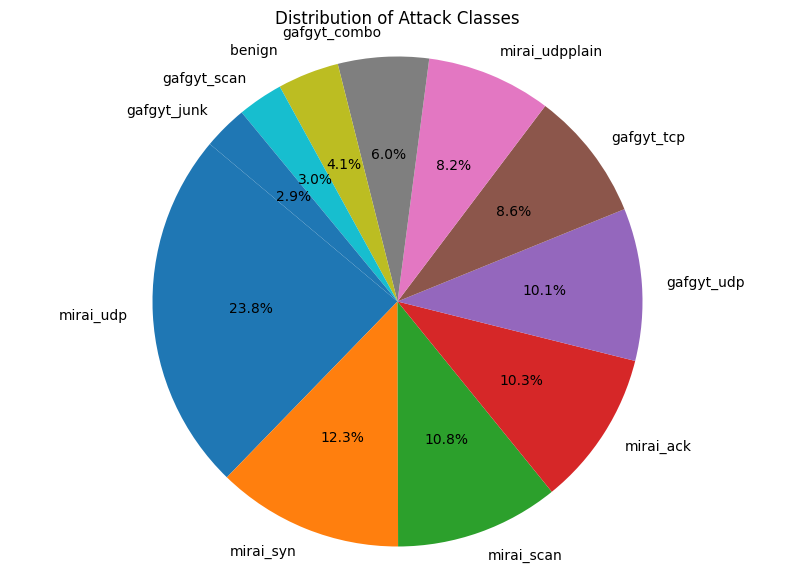

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

class_counts = df["Attack_Class"].value_counts()
total_samples = class_counts.sum()


# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Attack Classes")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [65]:
filtered_classes = ['mirai_udp', 'gafgyt_udp', 'benign     ']
filtered_df = df[df['Attack_Class'].isin(filtered_classes)]

# Take 40,000 samples from each class
sample_size = 25000
df_small = filtered_df.groupby('Attack_Class').apply(lambda x: x.sample(sample_size, replace=True)).reset_index(drop=True)

In [66]:
numeric_columns = df_small.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = df_small.select_dtypes(include=['object']).columns.tolist()

print("Numeric Columns:")
print(numeric_columns)
print("\nCategorical Columns:")
print(categorical_columns)

Numeric Columns:
['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', 'HH_L0.1_radius', 'HH_L0

In [67]:
# Remove columns that contain specific substrings
filtered_features = [feature for feature in numeric_columns if not any(substring in feature for substring in ['mean', 'variance', 'std', 'radius', 'magnitude', 'pcc'])]
print(f"Filtered features set: {filtered_features}")

Filtered features set: ['MI_dir_L5_weight', 'MI_dir_L3_weight', 'MI_dir_L1_weight', 'MI_dir_L0.1_weight', 'MI_dir_L0.01_weight', 'H_L5_weight', 'H_L3_weight', 'H_L1_weight', 'H_L0.1_weight', 'H_L0.01_weight', 'HH_L5_weight', 'HH_L3_weight', 'HH_L1_weight', 'HH_L0.1_weight', 'HH_L0.01_weight', 'HH_jit_L5_weight', 'HH_jit_L3_weight', 'HH_jit_L1_weight', 'HH_jit_L0.1_weight', 'HH_jit_L0.01_weight', 'HpHp_L5_weight', 'HpHp_L3_weight', 'HpHp_L1_weight', 'HpHp_L0.1_weight', 'HpHp_L0.01_weight']


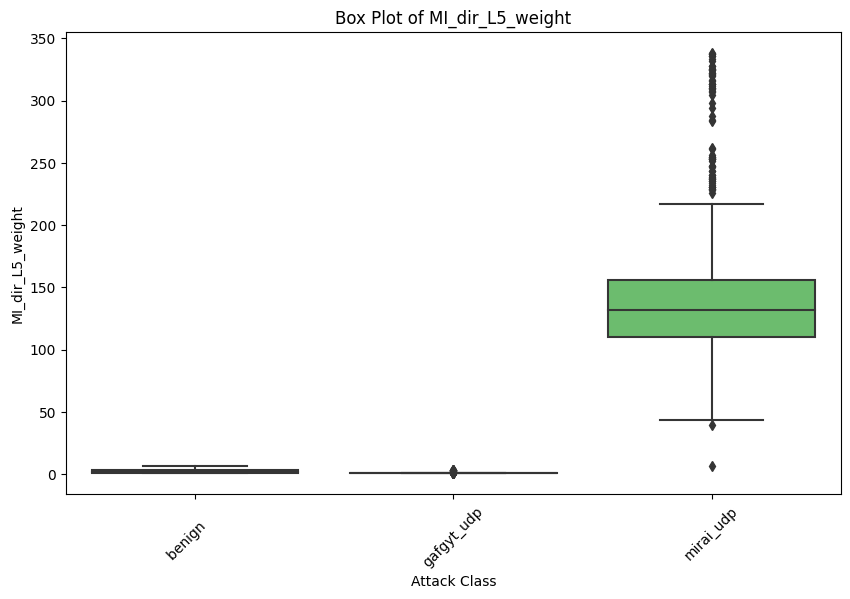

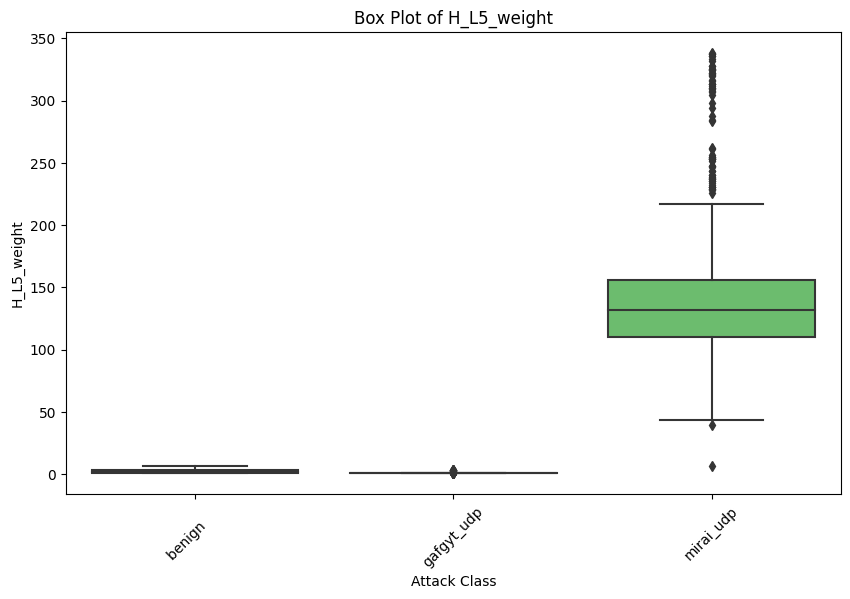

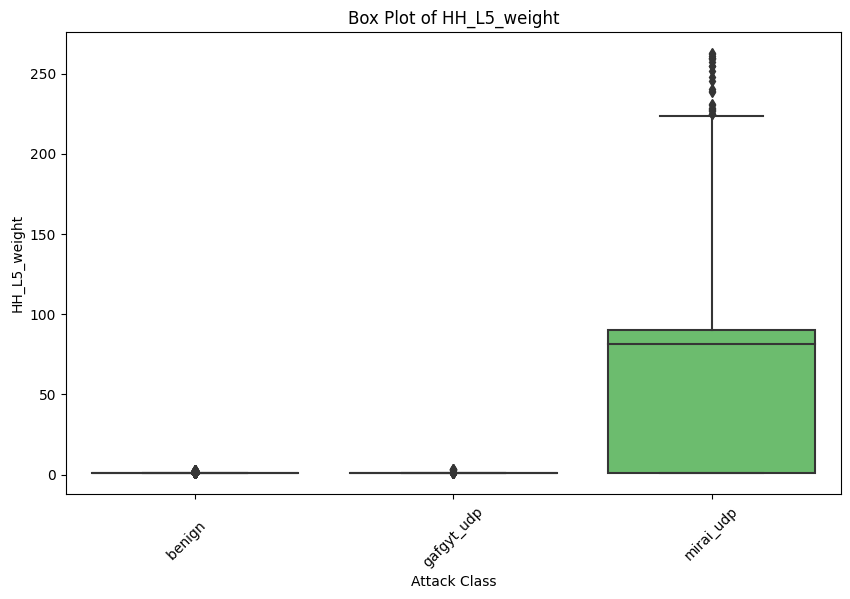

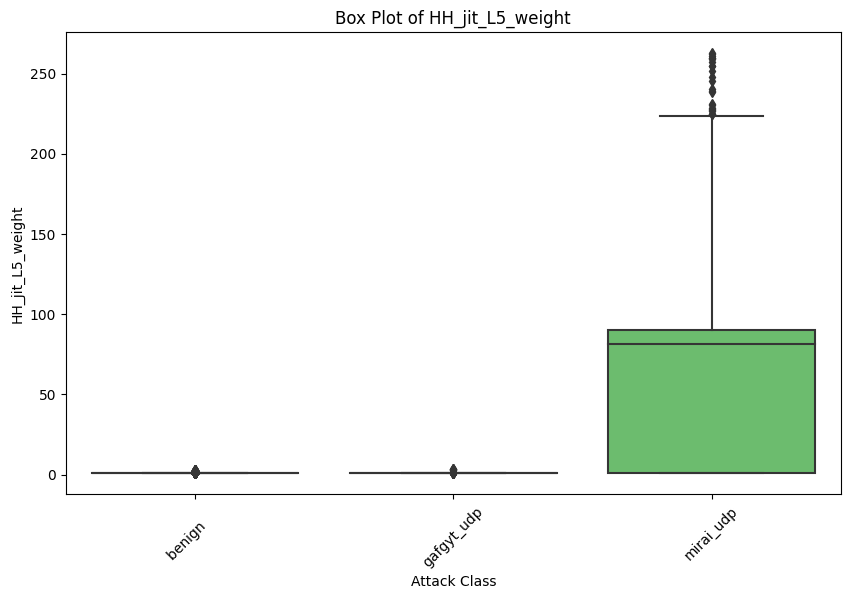

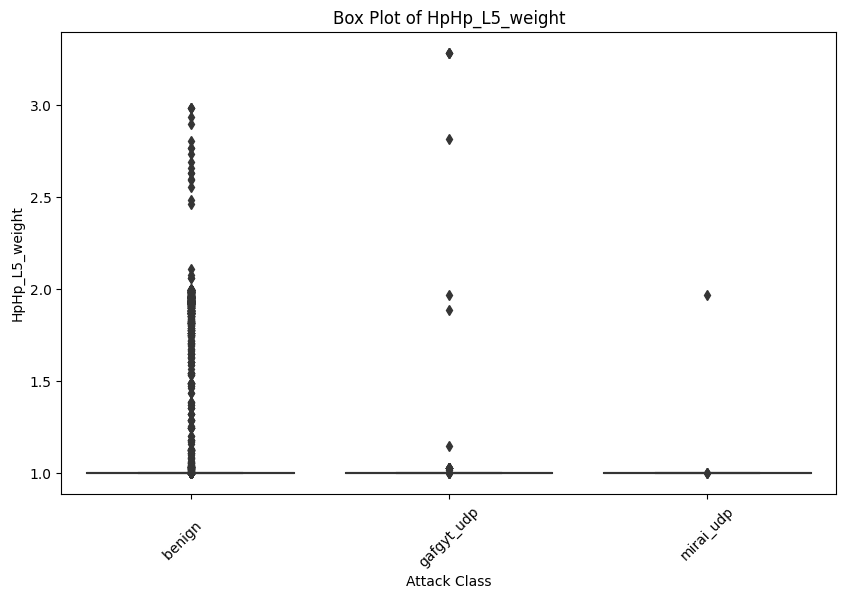

In [68]:
selected_features = ['MI_dir_L5_weight', 'H_L5_weight', 'HH_L5_weight', 'HH_jit_L5_weight', 'HpHp_L5_weight']
#Box Plots of a Few Important Features
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_small, x='Attack_Class', y=feature, palette='viridis')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Attack Class')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()


In [69]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Encode the Attack_Class column
le = LabelEncoder()
df_small['Attack_Class_Encoded'] = le.fit_transform(df_small['Attack_Class'])

# Split the data
X = df_small[selected_features]
y = df_small['Attack_Class_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Train MLP
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            1.00      0.62      0.76      7443
  gafgyt_udp       0.73      1.00      0.84      7625
   mirai_udp       1.00      1.00      1.00      7432

    accuracy                           0.87     22500
   macro avg       0.91      0.87      0.87     22500
weighted avg       0.91      0.87      0.87     22500



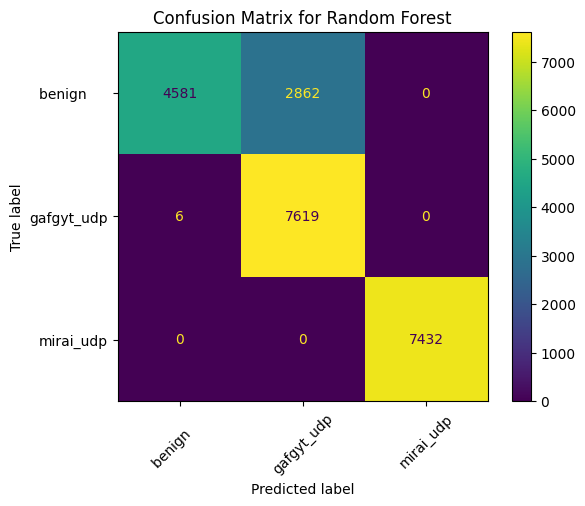

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            1.00      0.69      0.82      7443
  gafgyt_udp       0.77      1.00      0.87      7625
   mirai_udp       1.00      1.00      1.00      7432

    accuracy                           0.90     22500
   macro avg       0.92      0.90      0.90     22500
weighted avg       0.92      0.90      0.90     22500



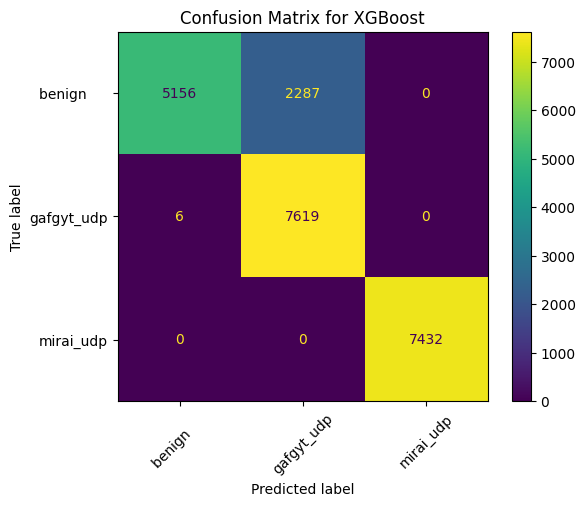

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            1.00      0.55      0.71      7443
  gafgyt_udp       0.69      1.00      0.82      7625
   mirai_udp       1.00      1.00      1.00      7432

    accuracy                           0.85     22500
   macro avg       0.90      0.85      0.84     22500
weighted avg       0.90      0.85      0.84     22500



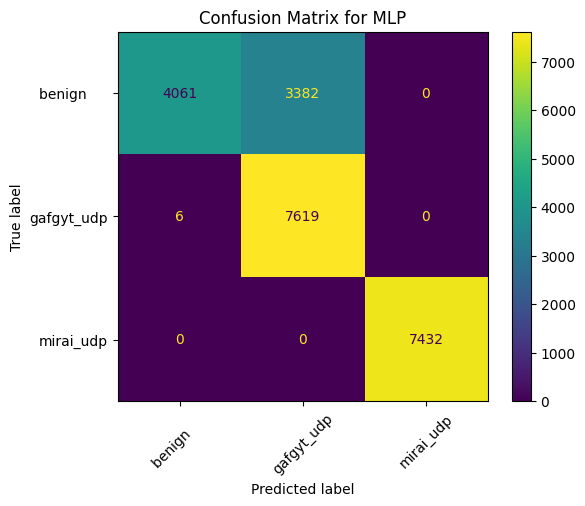

In [71]:
# Function to plot confusion matrix and classification report
def plot_evaluation_results(y_test, y_pred, model_name):
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='viridis')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.show()

# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            1.00      0.62      0.76      7443
  gafgyt_udp       0.73      1.00      0.84      7625
   mirai_udp       1.00      1.00      1.00      7432

    accuracy                           0.87     22500
   macro avg       0.91      0.87      0.87     22500
weighted avg       0.91      0.87      0.87     22500



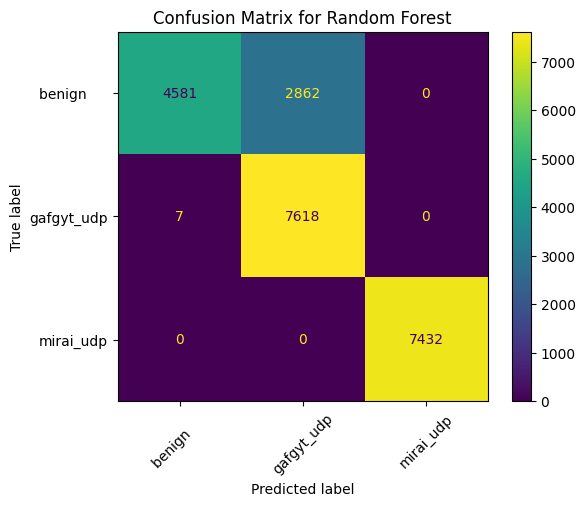

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            1.00      0.69      0.82      7443
  gafgyt_udp       0.77      1.00      0.87      7625
   mirai_udp       1.00      1.00      1.00      7432

    accuracy                           0.90     22500
   macro avg       0.92      0.90      0.90     22500
weighted avg       0.92      0.90      0.90     22500



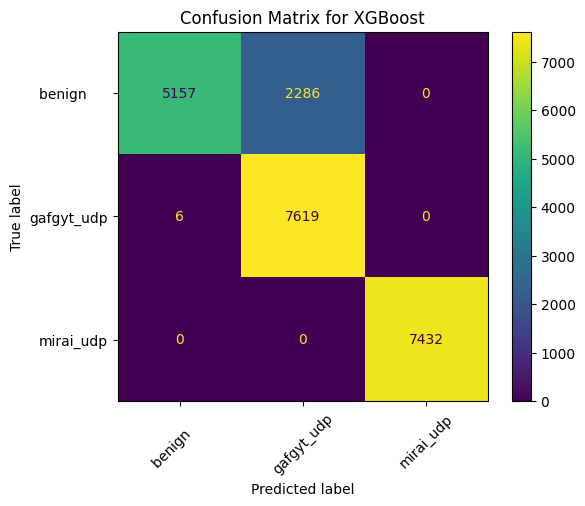

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            1.00      0.55      0.71      7443
  gafgyt_udp       0.69      1.00      0.82      7625
   mirai_udp       1.00      1.00      1.00      7432

    accuracy                           0.85     22500
   macro avg       0.90      0.85      0.84     22500
weighted avg       0.90      0.85      0.84     22500



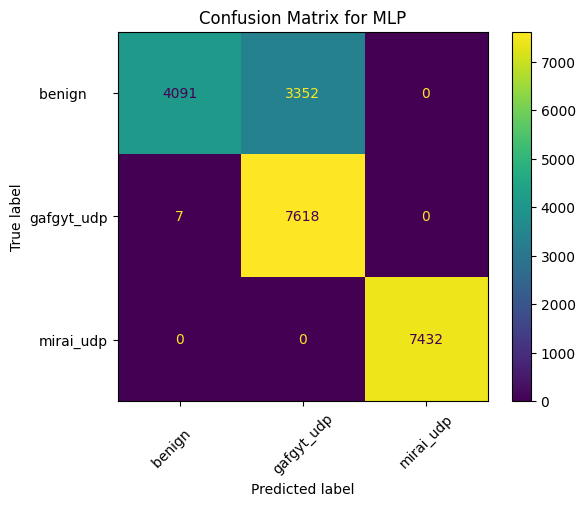

In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV



# Define parameter grids for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 9]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],'alpha': [0.0001, 0.001]
   
}

# Tune Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Tune XGBoost
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Tune MLP
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=3, n_jobs=-1, verbose=1)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)



# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

In [73]:
# Compare model performance to select the best one
best_model = None
best_score = 0

models = {
    "Random Forest": (best_rf, y_pred_rf),
    "XGBoost": (best_xgb, y_pred_xgb),
    "MLP": (best_mlp, y_pred_mlp)
}

for model_name, (model, y_pred) in models.items():
    score = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    if score > best_score:
        best_score = score
        best_model = model_name

print(f"The best model is: {best_model} with accuracy: {best_score}")

The best model is: XGBoost with accuracy: 0.8981333333333333


## Scan Attacks

In [74]:
filtered_classes = ['mirai_scan', 'gafgyt_scan', 'benign     ']
filtered_df = df[df['Attack_Class'].isin(filtered_classes)]

# Take 40,000 samples from each class
sample_size = 25000
df_small = filtered_df.groupby('Attack_Class').apply(lambda x: x.sample(sample_size, replace=True)).reset_index(drop=True)

In [75]:
numeric_columns = df_small.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = df_small.select_dtypes(include=['object']).columns.tolist()

print("Numeric Columns:")
print(numeric_columns)
print("\nCategorical Columns:")
print(categorical_columns)

Numeric Columns:
['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', 'HH_L0.1_radius', 'HH_L0

In [76]:
# Remove columns that contain specific substrings
filtered_features = [feature for feature in numeric_columns if not any(substring in feature for substring in ['mean', 'variance', 'std', 'radius', 'magnitude', 'pcc'])]
print(f"Filtered features set: {filtered_features}")

Filtered features set: ['MI_dir_L5_weight', 'MI_dir_L3_weight', 'MI_dir_L1_weight', 'MI_dir_L0.1_weight', 'MI_dir_L0.01_weight', 'H_L5_weight', 'H_L3_weight', 'H_L1_weight', 'H_L0.1_weight', 'H_L0.01_weight', 'HH_L5_weight', 'HH_L3_weight', 'HH_L1_weight', 'HH_L0.1_weight', 'HH_L0.01_weight', 'HH_jit_L5_weight', 'HH_jit_L3_weight', 'HH_jit_L1_weight', 'HH_jit_L0.1_weight', 'HH_jit_L0.01_weight', 'HpHp_L5_weight', 'HpHp_L3_weight', 'HpHp_L1_weight', 'HpHp_L0.1_weight', 'HpHp_L0.01_weight']


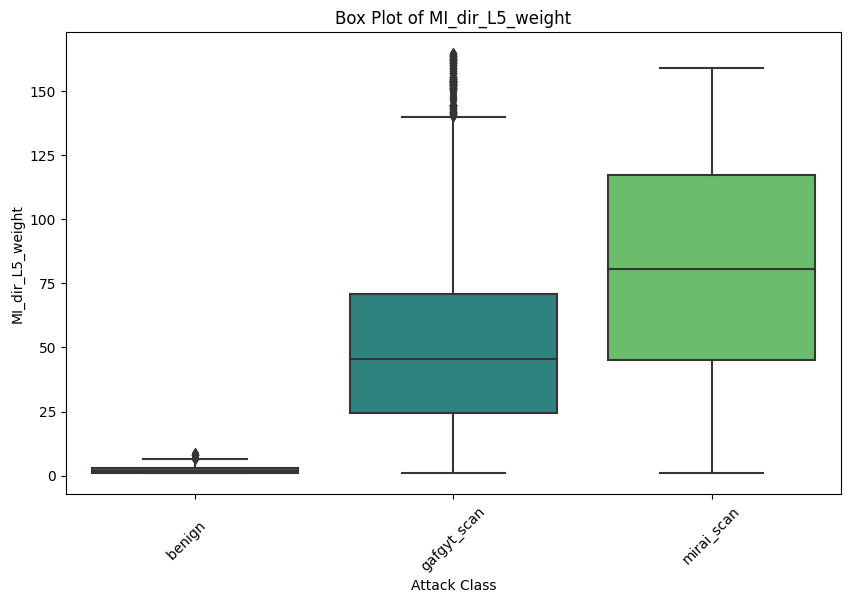

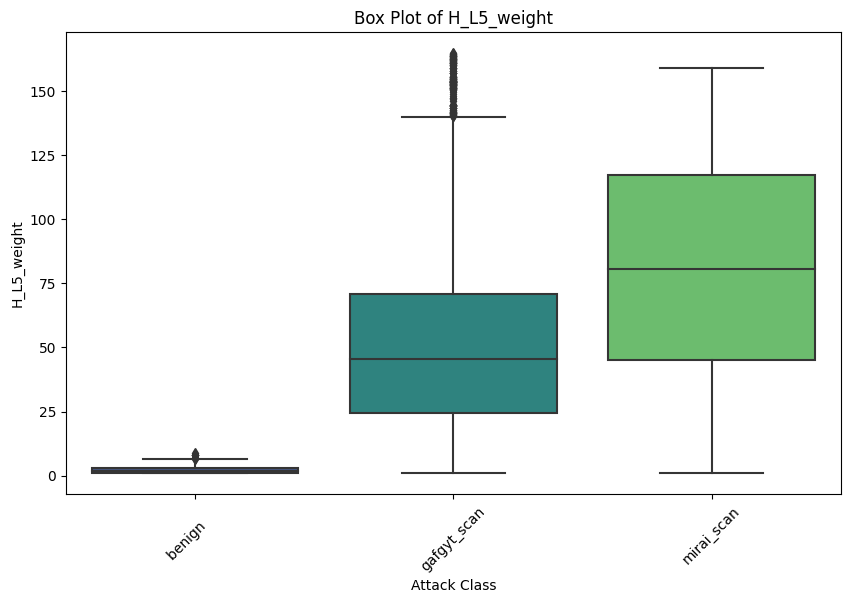

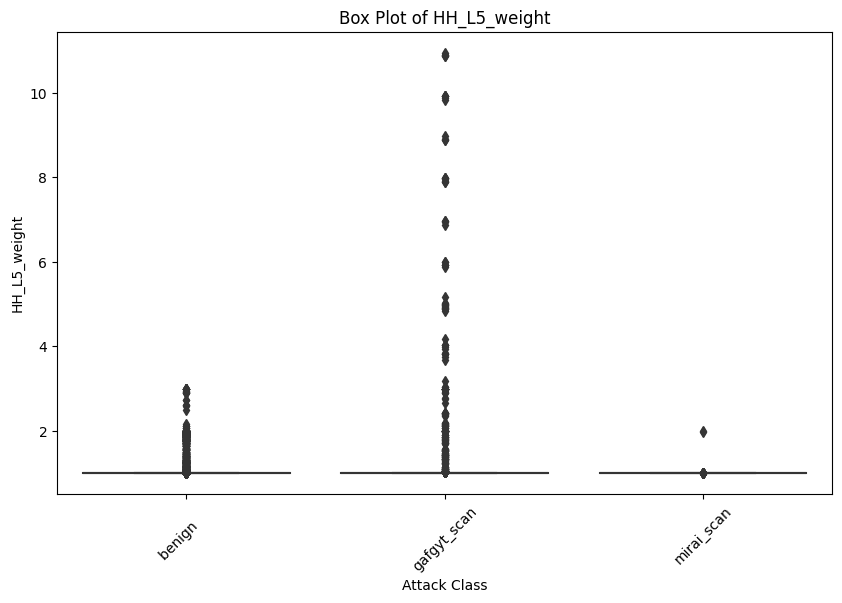

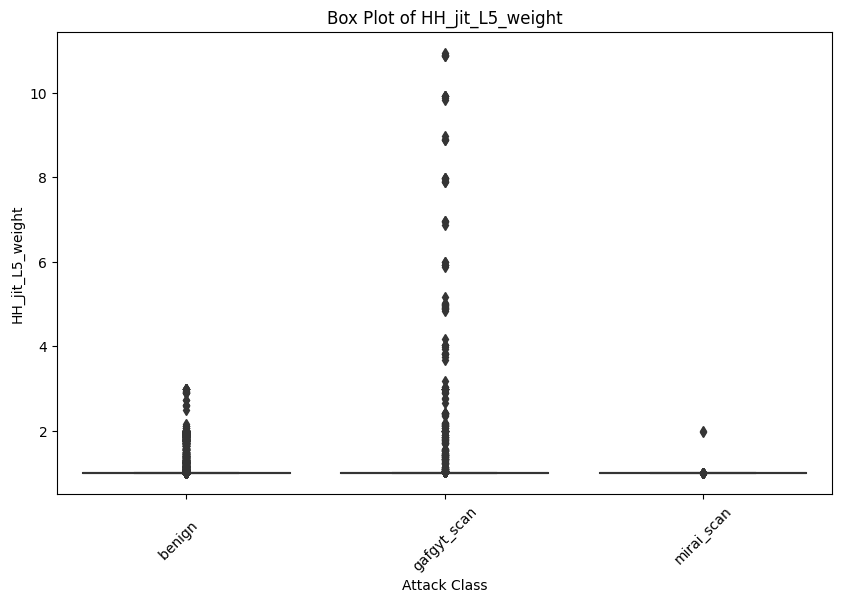

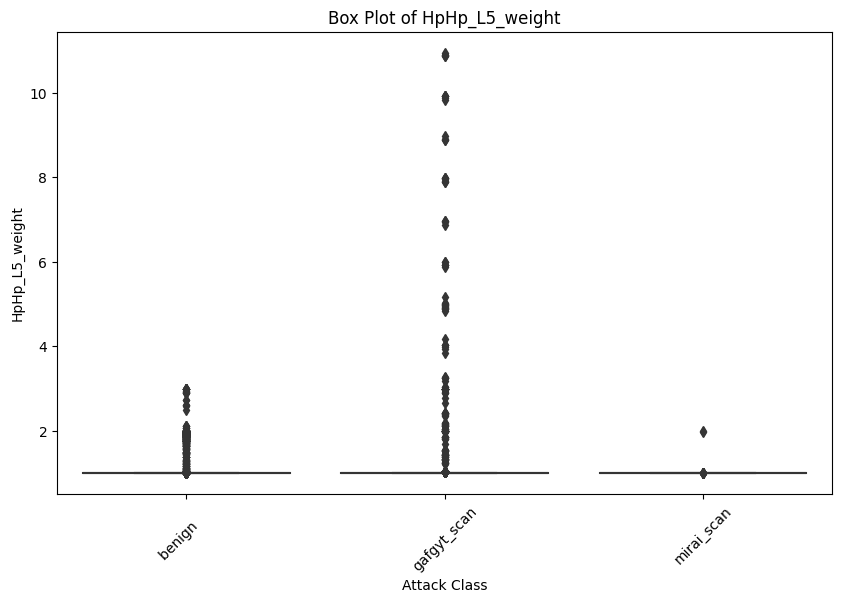

In [77]:
selected_features = ['MI_dir_L5_weight', 'H_L5_weight', 'HH_L5_weight', 'HH_jit_L5_weight', 'HpHp_L5_weight']
#Box Plots of a Few Important Features
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_small, x='Attack_Class', y=feature, palette='viridis')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Attack Class')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()


In [78]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Encode the Attack_Class column
le = LabelEncoder()
df_small['Attack_Class_Encoded'] = le.fit_transform(df_small['Attack_Class'])

# Split the data
X = df_small[selected_features]
y = df_small['Attack_Class_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Train MLP
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            0.99      0.99      0.99      7443
 gafgyt_scan       0.75      0.79      0.77      7625
  mirai_scan       0.78      0.75      0.77      7432

    accuracy                           0.84     22500
   macro avg       0.84      0.84      0.84     22500
weighted avg       0.84      0.84      0.84     22500



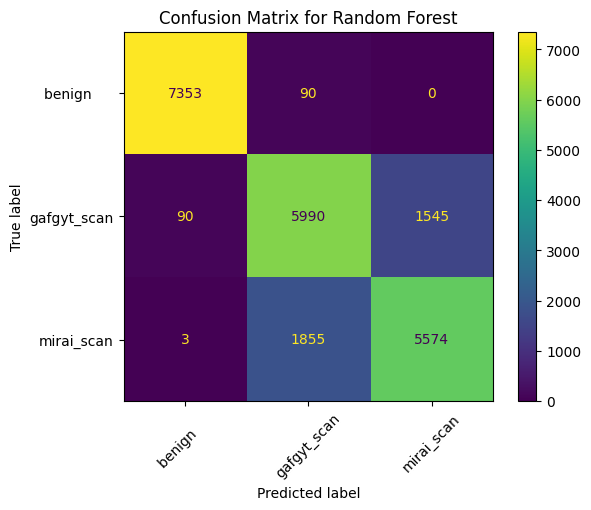

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            0.98      0.99      0.98      7443
 gafgyt_scan       0.72      0.66      0.69      7625
  mirai_scan       0.69      0.75      0.72      7432

    accuracy                           0.80     22500
   macro avg       0.80      0.80      0.80     22500
weighted avg       0.80      0.80      0.80     22500



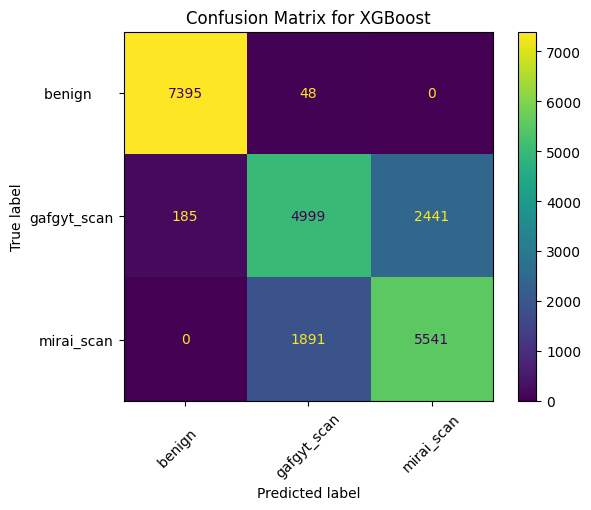

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            0.95      1.00      0.98      7443
 gafgyt_scan       0.62      0.76      0.68      7625
  mirai_scan       0.73      0.53      0.61      7432

    accuracy                           0.76     22500
   macro avg       0.77      0.76      0.76     22500
weighted avg       0.77      0.76      0.76     22500



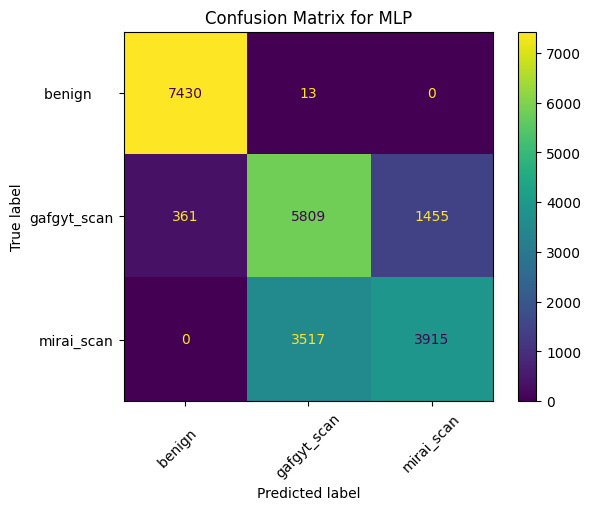

In [80]:
# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            0.98      0.99      0.99      7443
 gafgyt_scan       0.76      0.70      0.73      7625
  mirai_scan       0.73      0.78      0.75      7432

    accuracy                           0.82     22500
   macro avg       0.82      0.82      0.82     22500
weighted avg       0.82      0.82      0.82     22500



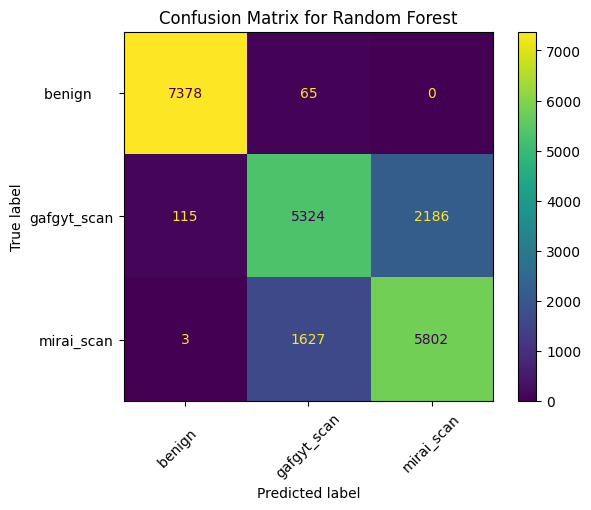

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            0.98      0.99      0.98      7443
 gafgyt_scan       0.72      0.65      0.69      7625
  mirai_scan       0.69      0.75      0.72      7432

    accuracy                           0.80     22500
   macro avg       0.80      0.80      0.80     22500
weighted avg       0.80      0.80      0.80     22500



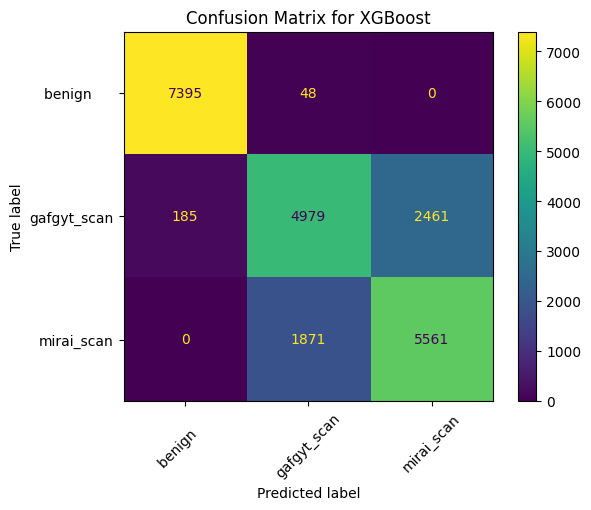

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            0.96      1.00      0.98      7443
 gafgyt_scan       0.61      0.86      0.71      7625
  mirai_scan       0.81      0.45      0.58      7432

    accuracy                           0.77     22500
   macro avg       0.79      0.77      0.76     22500
weighted avg       0.79      0.77      0.76     22500



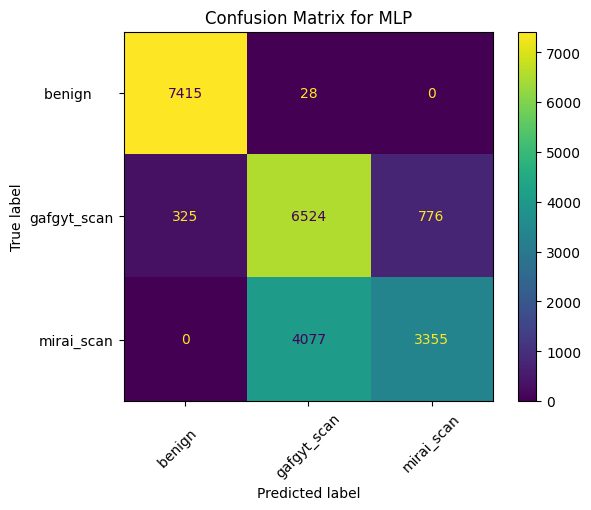

In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Define parameter grids for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 9]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],'alpha': [0.0001, 0.001]
   
}

# Tune Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Tune XGBoost
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Tune MLP
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=3, n_jobs=-1, verbose=1)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)



# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

In [82]:
# Compare model performance to select the best one
best_model = None
best_score = 0

models = {
    "Random Forest": (best_rf, y_pred_rf),
    "XGBoost": (best_xgb, y_pred_xgb),
    "MLP": (best_mlp, y_pred_mlp)
}

for model_name, (model, y_pred) in models.items():
    score = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    if score > best_score:
        best_score = score
        best_model = model_name

print(f"The best model is: {best_model} with accuracy: {best_score}")

The best model is: Random Forest with accuracy: 0.8224


## Device ID - 5

In [83]:
benign_df = pd.read_csv('../input/nbaiot-dataset/5.benign.csv')
m_a_df = pd.read_csv('../input/nbaiot-dataset/5.mirai.ack.csv')
m_sc_df = pd.read_csv('../input/nbaiot-dataset/5.mirai.scan.csv',engine='python')
m_sy_df = pd.read_csv('../input/nbaiot-dataset/5.mirai.syn.csv')
m_u_df = pd.read_csv('../input/nbaiot-dataset/5.mirai.udp.csv')
m_u_p_df = pd.read_csv('../input/nbaiot-dataset/5.mirai.udpplain.csv')
g_c_df = pd.read_csv('../input/nbaiot-dataset/5.gafgyt.combo.csv')
g_j_df = pd.read_csv('../input/nbaiot-dataset/5.gafgyt.junk.csv')
g_s_df = pd.read_csv('../input/nbaiot-dataset/5.gafgyt.scan.csv')
g_t_df = pd.read_csv('../input/nbaiot-dataset/5.gafgyt.tcp.csv')
g_u_df = pd.read_csv('../input/nbaiot-dataset/5.gafgyt.udp.csv')

In [84]:
benign_df['Attack_Class'] = 'benign     '
m_u_df['Attack_Class']    = 'mirai_udp'
m_a_df['Attack_Class']    = 'mirai_ack'
m_sc_df['Attack_Class']   = 'mirai_scan'
m_sy_df['Attack_Class']   = 'mirai_syn'
m_u_p_df['Attack_Class']  = 'mirai_udpplain'
g_c_df['Attack_Class']    = 'gafgyt_combo'
g_j_df['Attack_Class']    = 'gafgyt_junk'
g_s_df['Attack_Class']    = 'gafgyt_scan'
g_t_df['Attack_Class']    = 'gafgyt_tcp'
g_u_df['Attack_Class']    = 'gafgyt_udp'

In [85]:
df = pd.concat([benign_df,
                m_u_df, m_a_df, m_sc_df,m_sy_df, m_u_p_df,
                g_c_df,g_j_df, g_s_df, g_t_df,g_u_df],
                axis=0, sort=False, ignore_index=True)

In [86]:
df

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Attack_Class
0,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,benign
1,1.000000,590.000000,0.000000,1.000000,590.0000,0.000000e+00,1.000000,590.000000,0.000000,1.000000,...,0.0,0.0,6.302352,416.121686,113.526005,416.121686,12888.15384,0.0,0.0,benign
2,1.942585,590.000000,0.000000,1.965145,590.0000,1.160000e-10,1.988244,590.000000,0.000000,1.998818,...,0.0,0.0,7.301607,439.935392,121.229684,439.935392,14696.63622,0.0,0.0,benign
3,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,benign
4,1.979600,66.061831,35.996177,1.987709,66.0371,3.599862e+01,1.995886,66.012367,35.999847,1.999588,...,0.0,0.0,1.000000,72.000000,0.000000,72.000000,0.00000,0.0,0.0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828255,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,gafgyt_udp
828256,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,gafgyt_udp
828257,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,gafgyt_udp
828258,1.000000,60.000000,0.000000,1.000000,60.0000,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.00000,0.0,0.0,gafgyt_udp


In [87]:
print(df.duplicated().sum(), "fully duplicate rows to remove")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

20424 fully duplicate rows to remove


(807836, 116)

In [88]:
class_counts = df["Attack_Class"].value_counts()
total_samples = class_counts.sum()
# Display the classes along with the number of samples
print("Serial\tAttack_Class\t\tNumber of Samples")
print("-----------------------------------")
serial_number = 1
for class_name, count in class_counts.items():
    print(f"{serial_number}\t{class_name}\t\t{count}")
    serial_number += 1
print("-----------------------------------")
print(f"Total Samples:                  {total_samples}")

Serial	Attack_Class		Number of Samples
-----------------------------------
1	mirai_udp		156248
2	gafgyt_udp		98424
3	mirai_scan		96781
4	gafgyt_tcp		96658
5	mirai_syn		65746
6	gafgyt_combo		61380
7	mirai_ack		60554
8	mirai_udpplain		56681
9	benign     		55169
10	gafgyt_junk		30898
11	gafgyt_scan		29297
-----------------------------------
Total Samples:                  807836


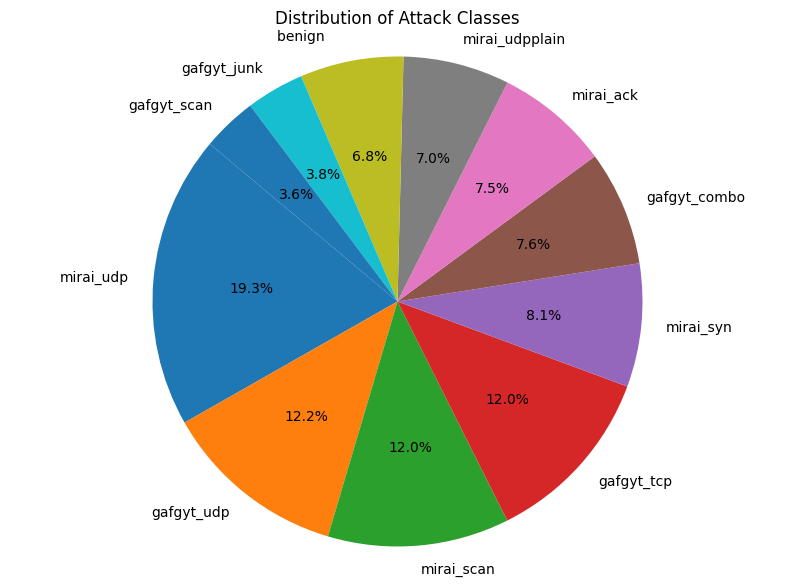

In [90]:
class_counts = df["Attack_Class"].value_counts()
total_samples = class_counts.sum()


# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Attack Classes")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [91]:
filtered_classes = ['mirai_udp', 'gafgyt_udp', 'benign     ']
filtered_df = df[df['Attack_Class'].isin(filtered_classes)]

# Take 40,000 samples from each class
sample_size = 40000
df_small = filtered_df.groupby('Attack_Class').apply(lambda x: x.sample(sample_size, replace=True)).reset_index(drop=True)

In [92]:
numeric_columns = df_small.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = df_small.select_dtypes(include=['object']).columns.tolist()

print("Numeric Columns:")
print(numeric_columns)
print("\nCategorical Columns:")
print(categorical_columns)

Numeric Columns:
['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', 'HH_L0.1_radius', 'HH_L0

In [93]:
# Remove columns that contain specific substrings
filtered_features = [feature for feature in numeric_columns if not any(substring in feature for substring in ['mean', 'variance', 'std', 'radius', 'magnitude', 'pcc'])]
print(f"Filtered features set: {filtered_features}")

Filtered features set: ['MI_dir_L5_weight', 'MI_dir_L3_weight', 'MI_dir_L1_weight', 'MI_dir_L0.1_weight', 'MI_dir_L0.01_weight', 'H_L5_weight', 'H_L3_weight', 'H_L1_weight', 'H_L0.1_weight', 'H_L0.01_weight', 'HH_L5_weight', 'HH_L3_weight', 'HH_L1_weight', 'HH_L0.1_weight', 'HH_L0.01_weight', 'HH_jit_L5_weight', 'HH_jit_L3_weight', 'HH_jit_L1_weight', 'HH_jit_L0.1_weight', 'HH_jit_L0.01_weight', 'HpHp_L5_weight', 'HpHp_L3_weight', 'HpHp_L1_weight', 'HpHp_L0.1_weight', 'HpHp_L0.01_weight']


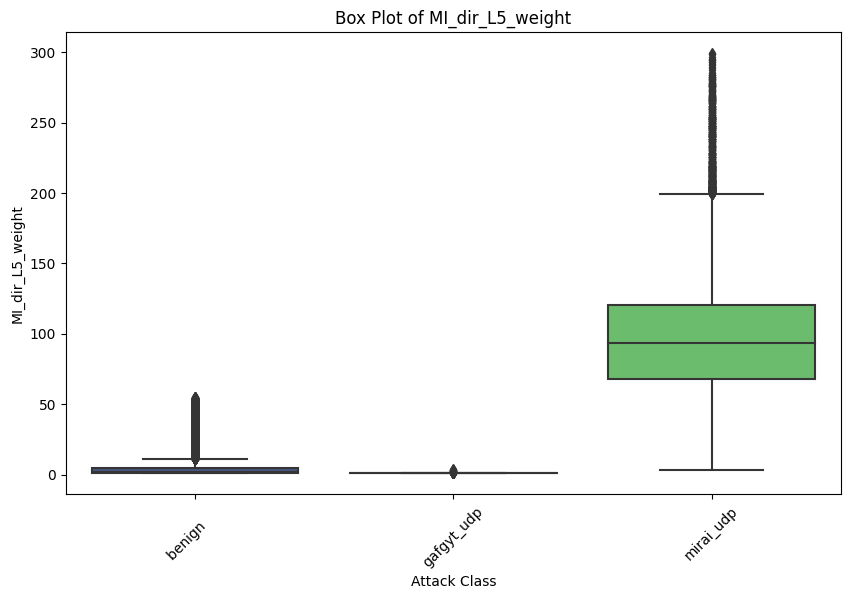

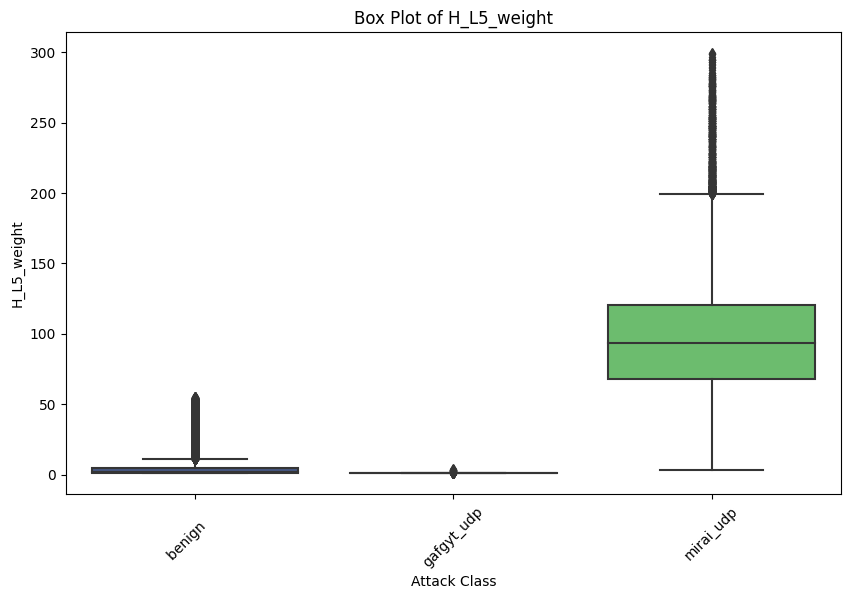

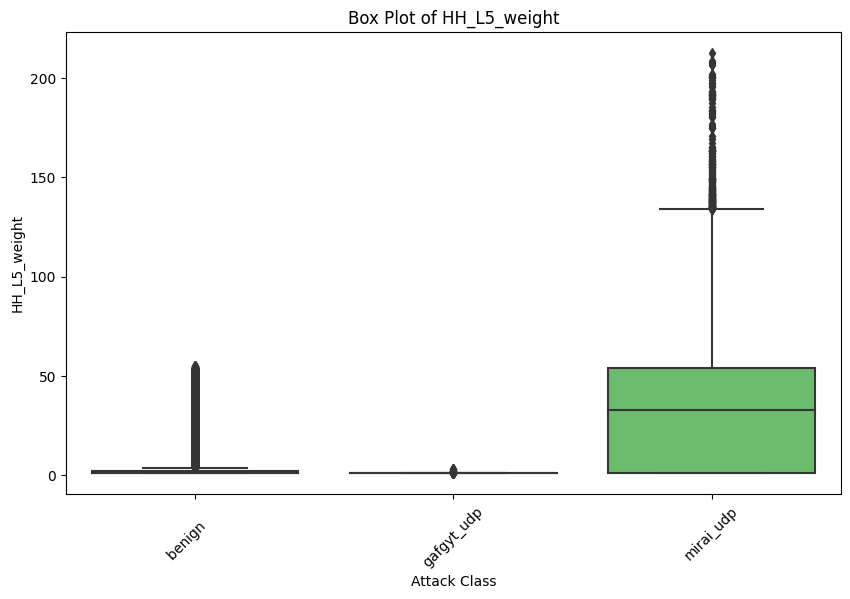

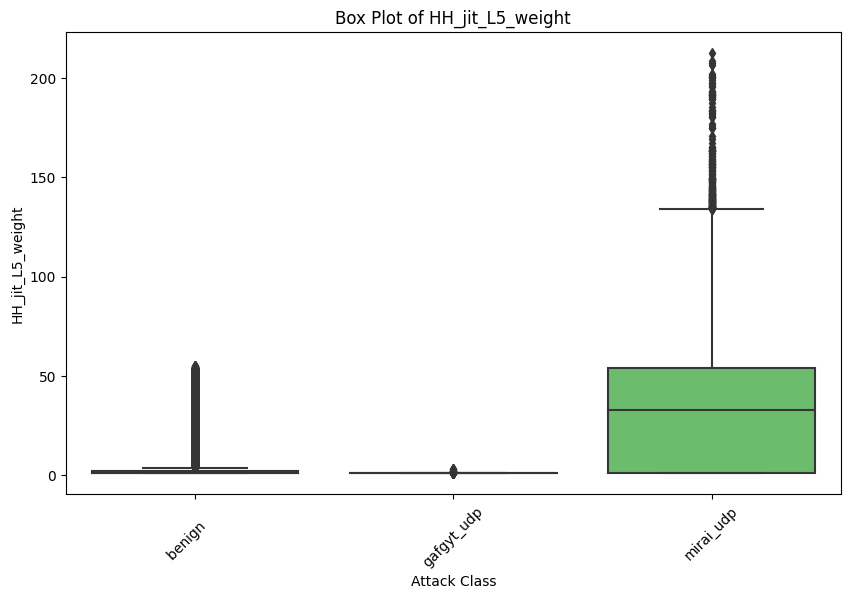

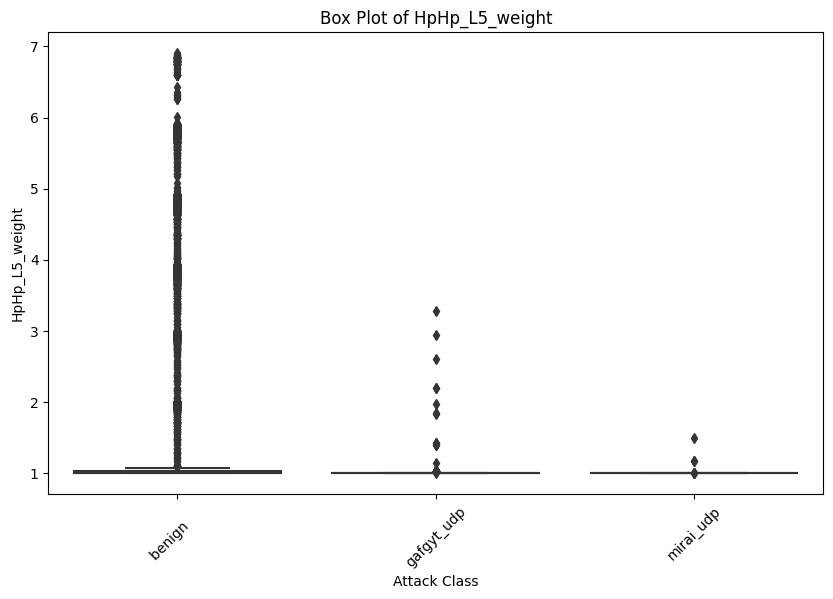

In [94]:
selected_features = ['MI_dir_L5_weight', 'H_L5_weight', 'HH_L5_weight', 'HH_jit_L5_weight', 'HpHp_L5_weight']
#Box Plots of a Few Important Features
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_small, x='Attack_Class', y=feature, palette='viridis')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Attack Class')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()


Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            0.99      0.72      0.84     12059
  gafgyt_udp       0.78      1.00      0.88     12100
   mirai_udp       1.00      1.00      1.00     11841

    accuracy                           0.90     36000
   macro avg       0.93      0.91      0.90     36000
weighted avg       0.92      0.90      0.90     36000



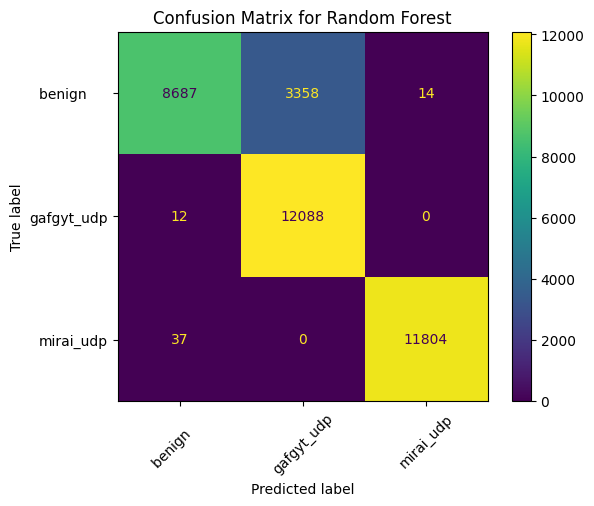

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            0.99      0.78      0.87     12059
  gafgyt_udp       0.82      1.00      0.90     12100
   mirai_udp       1.00      1.00      1.00     11841

    accuracy                           0.92     36000
   macro avg       0.94      0.92      0.92     36000
weighted avg       0.94      0.92      0.92     36000



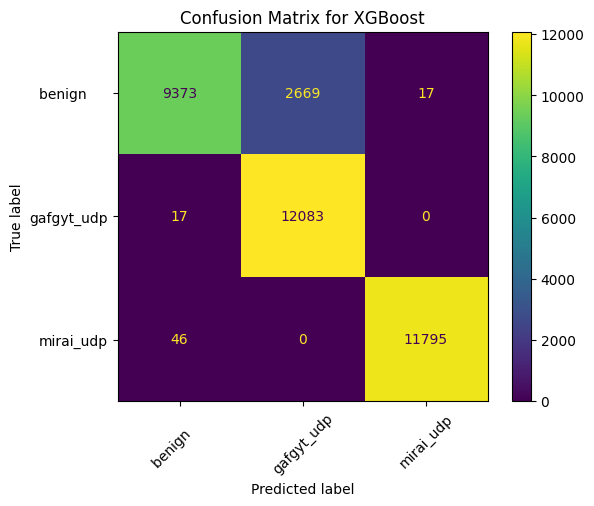

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            0.99      0.65      0.79     12059
  gafgyt_udp       0.74      1.00      0.85     12100
   mirai_udp       1.00      1.00      1.00     11841

    accuracy                           0.88     36000
   macro avg       0.91      0.88      0.88     36000
weighted avg       0.91      0.88      0.88     36000



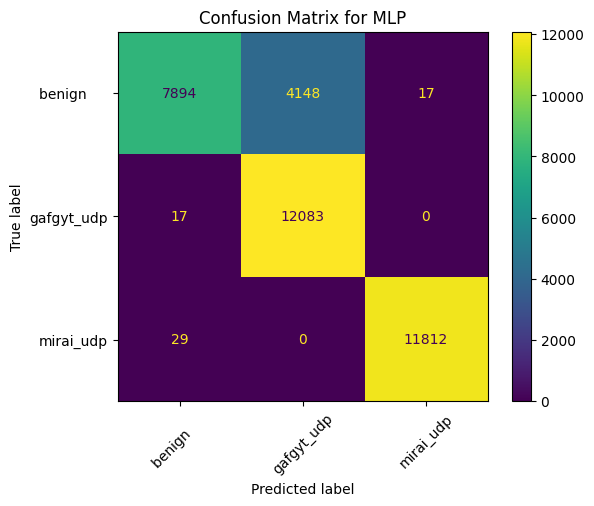

In [95]:
# Encode the Attack_Class column
le = LabelEncoder()
df_small['Attack_Class_Encoded'] = le.fit_transform(df_small['Attack_Class'])

# Split the data
X = df_small[selected_features]
y = df_small['Attack_Class_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Train MLP
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            0.99      0.72      0.84     12059
  gafgyt_udp       0.78      1.00      0.88     12100
   mirai_udp       1.00      1.00      1.00     11841

    accuracy                           0.90     36000
   macro avg       0.93      0.91      0.90     36000
weighted avg       0.92      0.90      0.90     36000



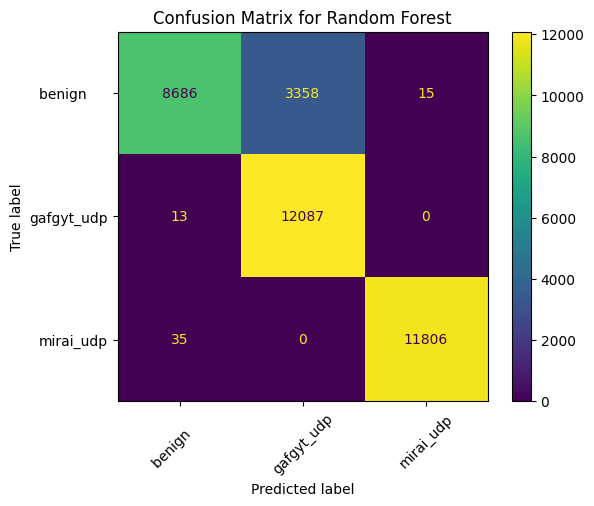

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            0.99      0.78      0.87     12059
  gafgyt_udp       0.82      1.00      0.90     12100
   mirai_udp       1.00      1.00      1.00     11841

    accuracy                           0.92     36000
   macro avg       0.94      0.92      0.92     36000
weighted avg       0.94      0.92      0.92     36000



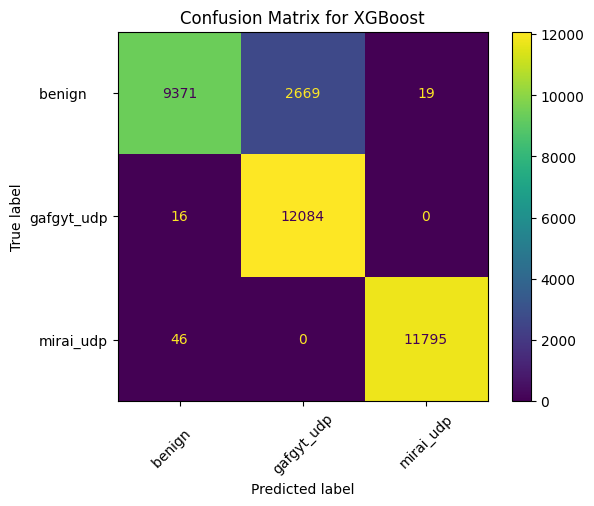

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            0.99      0.65      0.79     12059
  gafgyt_udp       0.74      1.00      0.85     12100
   mirai_udp       1.00      1.00      1.00     11841

    accuracy                           0.88     36000
   macro avg       0.91      0.88      0.88     36000
weighted avg       0.91      0.88      0.88     36000



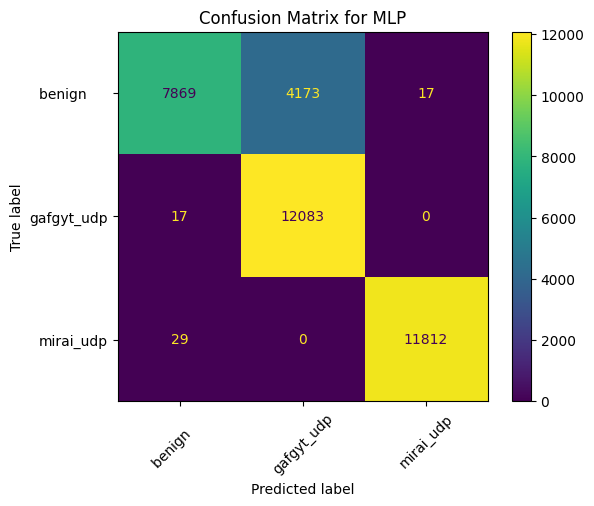

In [96]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Define parameter grids for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 9]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],'alpha': [0.0001, 0.001]
   
}

# Tune Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Tune XGBoost
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Tune MLP
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=3, n_jobs=-1, verbose=1)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

In [97]:
# Compare model performance to select the best one
best_model = None
best_score = 0

models = {
    "Random Forest": (best_rf, y_pred_rf),
    "XGBoost": (best_xgb, y_pred_xgb),
    "MLP": (best_mlp, y_pred_mlp)
}

for model_name, (model, y_pred) in models.items():
    score = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    if score > best_score:
        best_score = score
        best_model = model_name

print(f"The best model is: {best_model} with accuracy: {best_score}")

The best model is: XGBoost with accuracy: 0.9236111111111112


## Scan Data

In [98]:
filtered_classes = ['mirai_scan', 'gafgyt_scan', 'benign     ']
filtered_df = df[df['Attack_Class'].isin(filtered_classes)]

# Take 28000 samples from each class
sample_size = 28000
df_small = filtered_df.groupby('Attack_Class').apply(lambda x: x.sample(sample_size, replace=True)).reset_index(drop=True)

numeric_columns = df_small.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = df_small.select_dtypes(include=['object']).columns.tolist()

print("Numeric Columns:")
print(numeric_columns)
print("\nCategorical Columns:")
print(categorical_columns)


# Remove columns that contain specific substrings
filtered_features = [feature for feature in numeric_columns if not any(substring in feature for substring in ['mean', 'variance', 'std', 'radius', 'magnitude', 'pcc'])]
print(f"Filtered features set: {filtered_features}")

Numeric Columns:
['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', 'HH_L0.1_radius', 'HH_L0

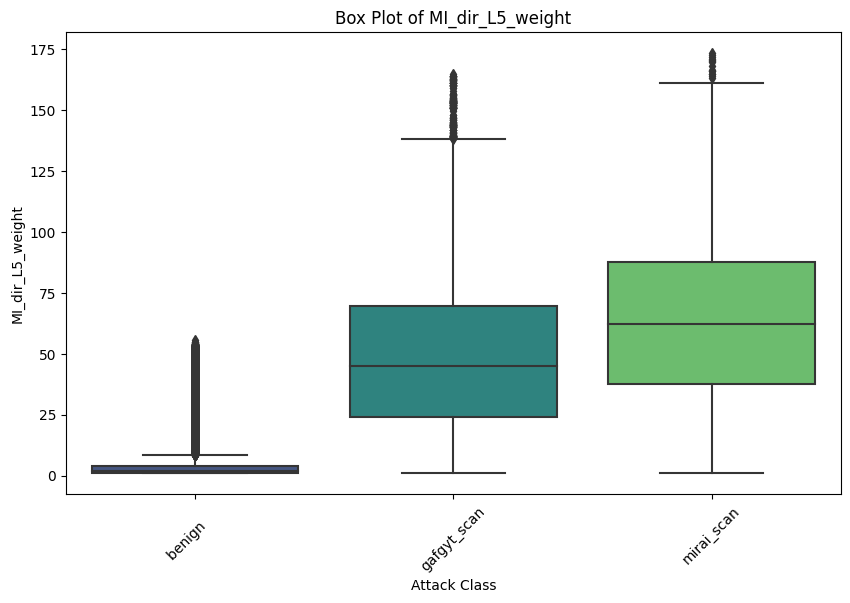

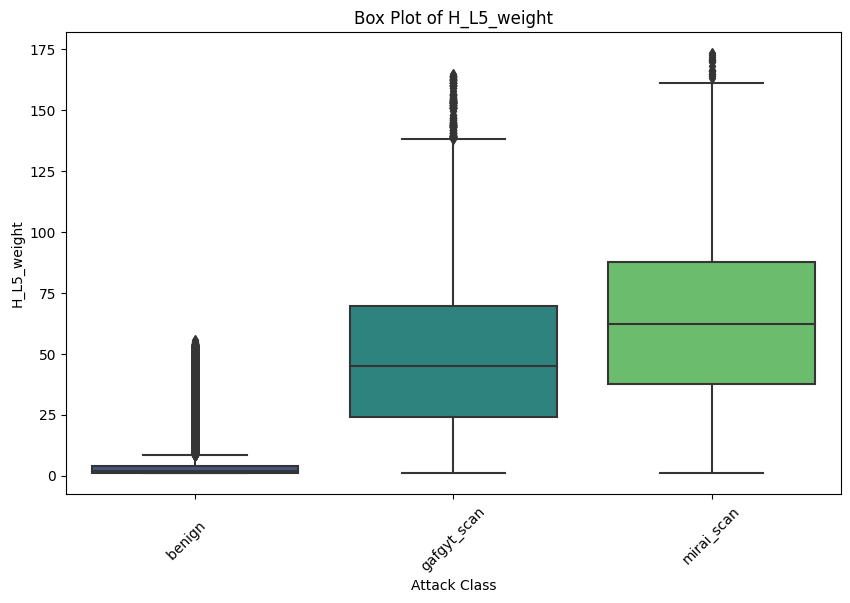

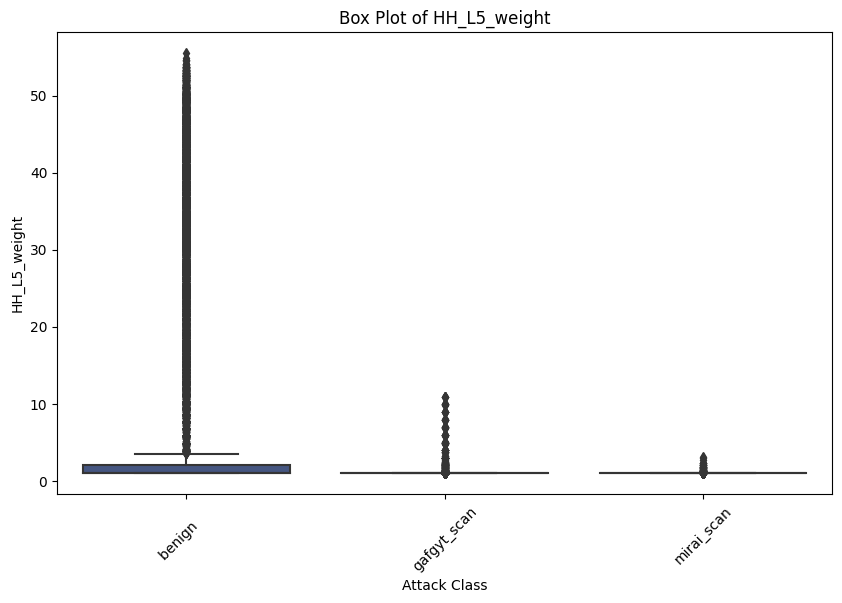

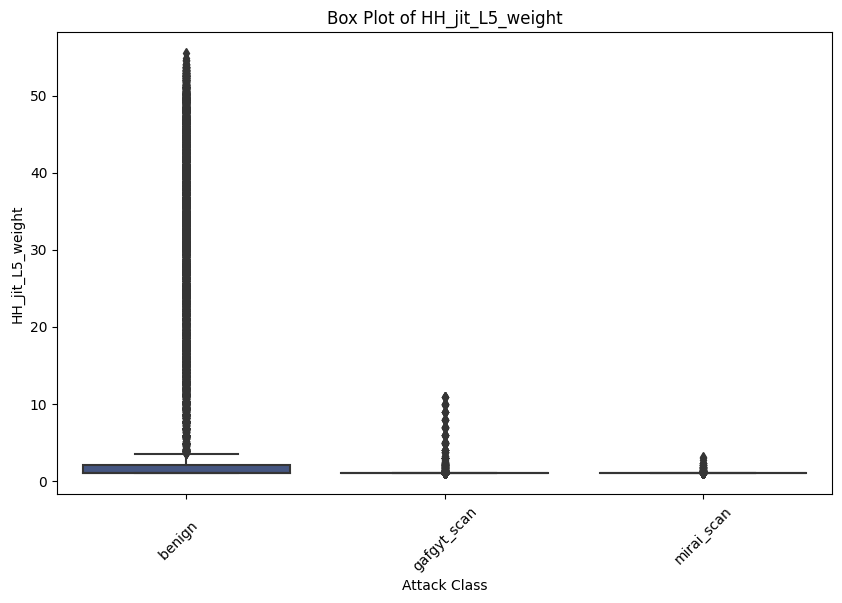

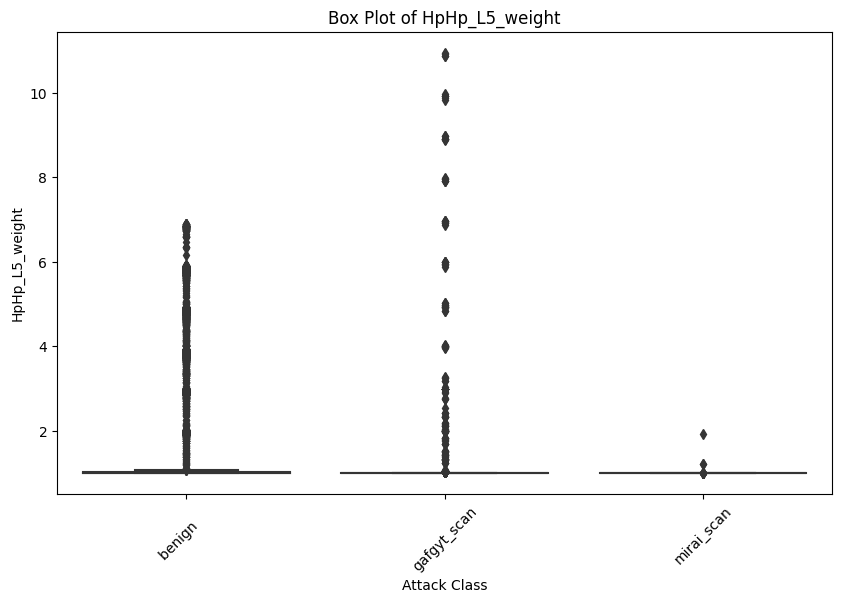

In [99]:
selected_features = ['MI_dir_L5_weight', 'H_L5_weight', 'HH_L5_weight', 'HH_jit_L5_weight', 'HpHp_L5_weight']
#Box Plots of a Few Important Features
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_small, x='Attack_Class', y=feature, palette='viridis')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel('Attack Class')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()

Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            0.99      0.99      0.99      8266
 gafgyt_scan       0.75      0.78      0.76      8526
  mirai_scan       0.77      0.74      0.76      8408

    accuracy                           0.84     25200
   macro avg       0.84      0.84      0.84     25200
weighted avg       0.84      0.84      0.84     25200



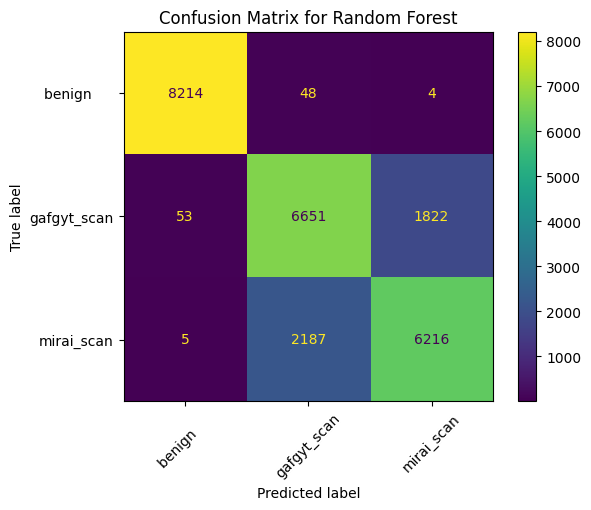

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            0.99      0.99      0.99      8266
 gafgyt_scan       0.77      0.51      0.62      8526
  mirai_scan       0.64      0.85      0.73      8408

    accuracy                           0.78     25200
   macro avg       0.80      0.79      0.78     25200
weighted avg       0.80      0.78      0.78     25200



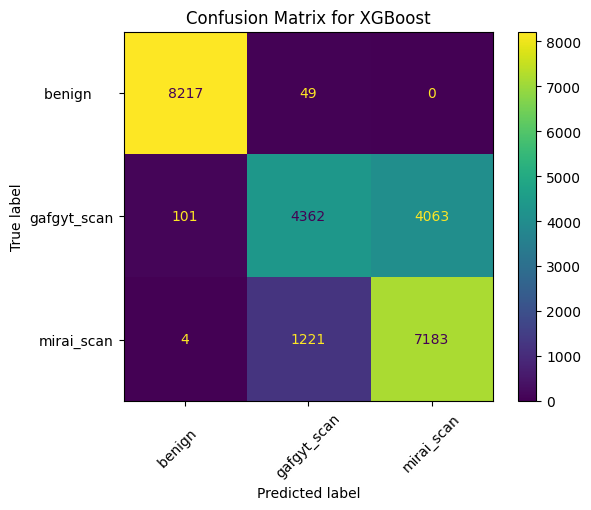

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            0.98      0.99      0.99      8266
 gafgyt_scan       0.60      0.45      0.51      8526
  mirai_scan       0.57      0.70      0.63      8408

    accuracy                           0.71     25200
   macro avg       0.72      0.72      0.71     25200
weighted avg       0.71      0.71      0.71     25200



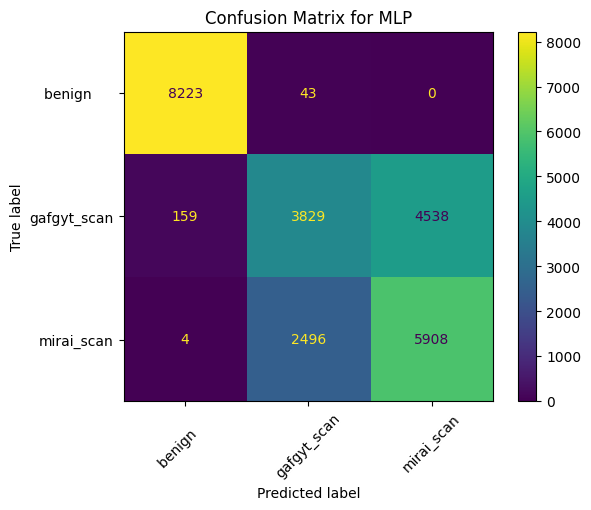

In [100]:
# Encode the Attack_Class column
le = LabelEncoder()
df_small['Attack_Class_Encoded'] = le.fit_transform(df_small['Attack_Class'])

# Split the data
X = df_small[selected_features]
y = df_small['Attack_Class_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Train MLP
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Classification Report for Random Forest:
              precision    recall  f1-score   support

 benign            0.99      0.99      0.99      8266
 gafgyt_scan       0.79      0.58      0.67      8526
  mirai_scan       0.67      0.85      0.75      8408

    accuracy                           0.81     25200
   macro avg       0.82      0.81      0.81     25200
weighted avg       0.82      0.81      0.80     25200



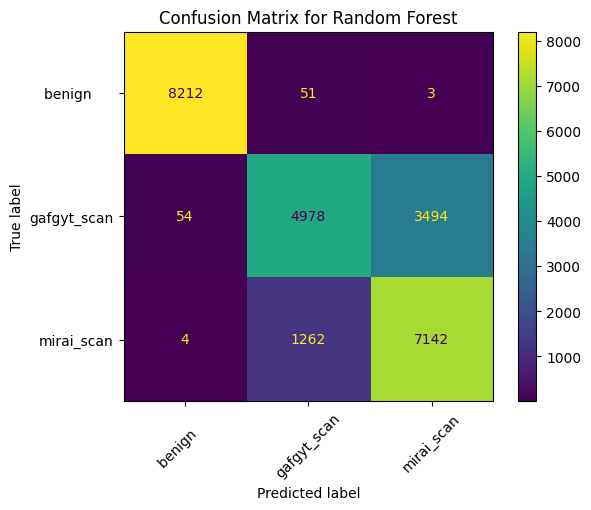

Classification Report for XGBoost:
              precision    recall  f1-score   support

 benign            0.99      0.99      0.99      8266
 gafgyt_scan       0.77      0.52      0.62      8526
  mirai_scan       0.64      0.85      0.73      8408

    accuracy                           0.78     25200
   macro avg       0.80      0.79      0.78     25200
weighted avg       0.80      0.78      0.78     25200



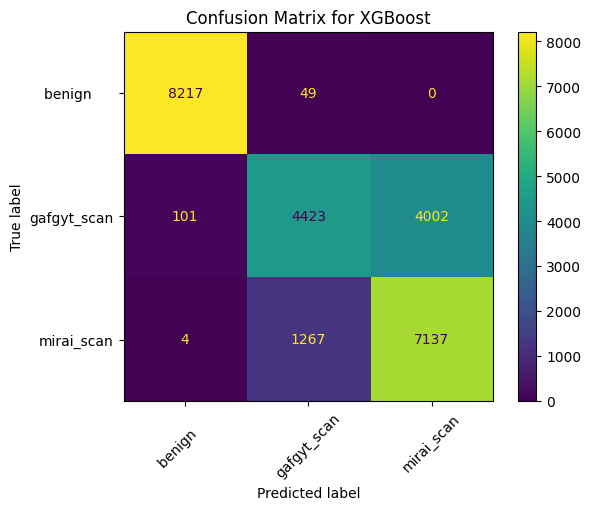

Classification Report for MLP:
              precision    recall  f1-score   support

 benign            0.98      1.00      0.99      8266
 gafgyt_scan       0.58      0.63      0.60      8526
  mirai_scan       0.60      0.54      0.57      8408

    accuracy                           0.72     25200
   macro avg       0.72      0.72      0.72     25200
weighted avg       0.72      0.72      0.72     25200



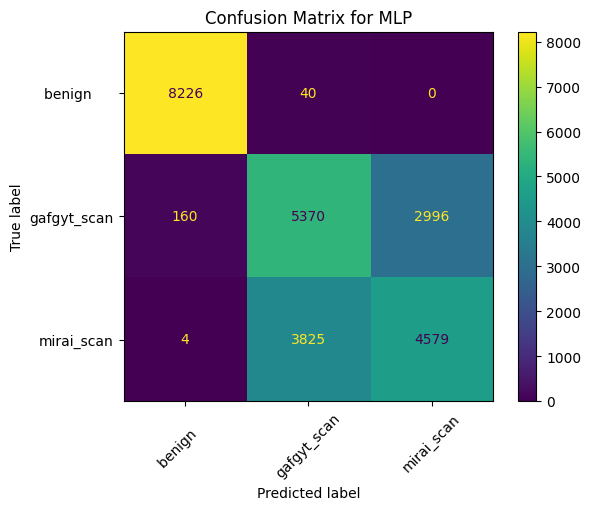

The best model is: Random Forest with accuracy: 0.8068253968253968


In [101]:
# Tune Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Tune XGBoost
grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Tune MLP
grid_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=3, n_jobs=-1, verbose=1)
grid_mlp.fit(X_train, y_train)
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

# Evaluate Random Forest
plot_evaluation_results(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
plot_evaluation_results(y_test, y_pred_xgb, "XGBoost")

# Evaluate MLP
plot_evaluation_results(y_test, y_pred_mlp, "MLP")


# Compare model performance to select the best one
best_model = None
best_score = 0

models = {
    "Random Forest": (best_rf, y_pred_rf),
    "XGBoost": (best_xgb, y_pred_xgb),
    "MLP": (best_mlp, y_pred_mlp)
}

for model_name, (model, y_pred) in models.items():
    score = classification_report(y_test, y_pred, output_dict=True)['accuracy']
    if score > best_score:
        best_score = score
        best_model = model_name

print(f"The best model is: {best_model} with accuracy: {best_score}")